<a href="https://colab.research.google.com/github/massinoLight/ProjetNedra/blob/main/projetNedra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterisation non supervisée d'images
 Dans ce notbook nous essayons de combiner deux methodes de ML 
 l'une qui est suppérvisé c'est (la partie CNN)afin d'extraire les caractéristiques propre a une image 
 la seconde est le k-means afin de faire le clustering des vecteurs issues du premier traitement de CNN  

##Architecture de notre modéle 

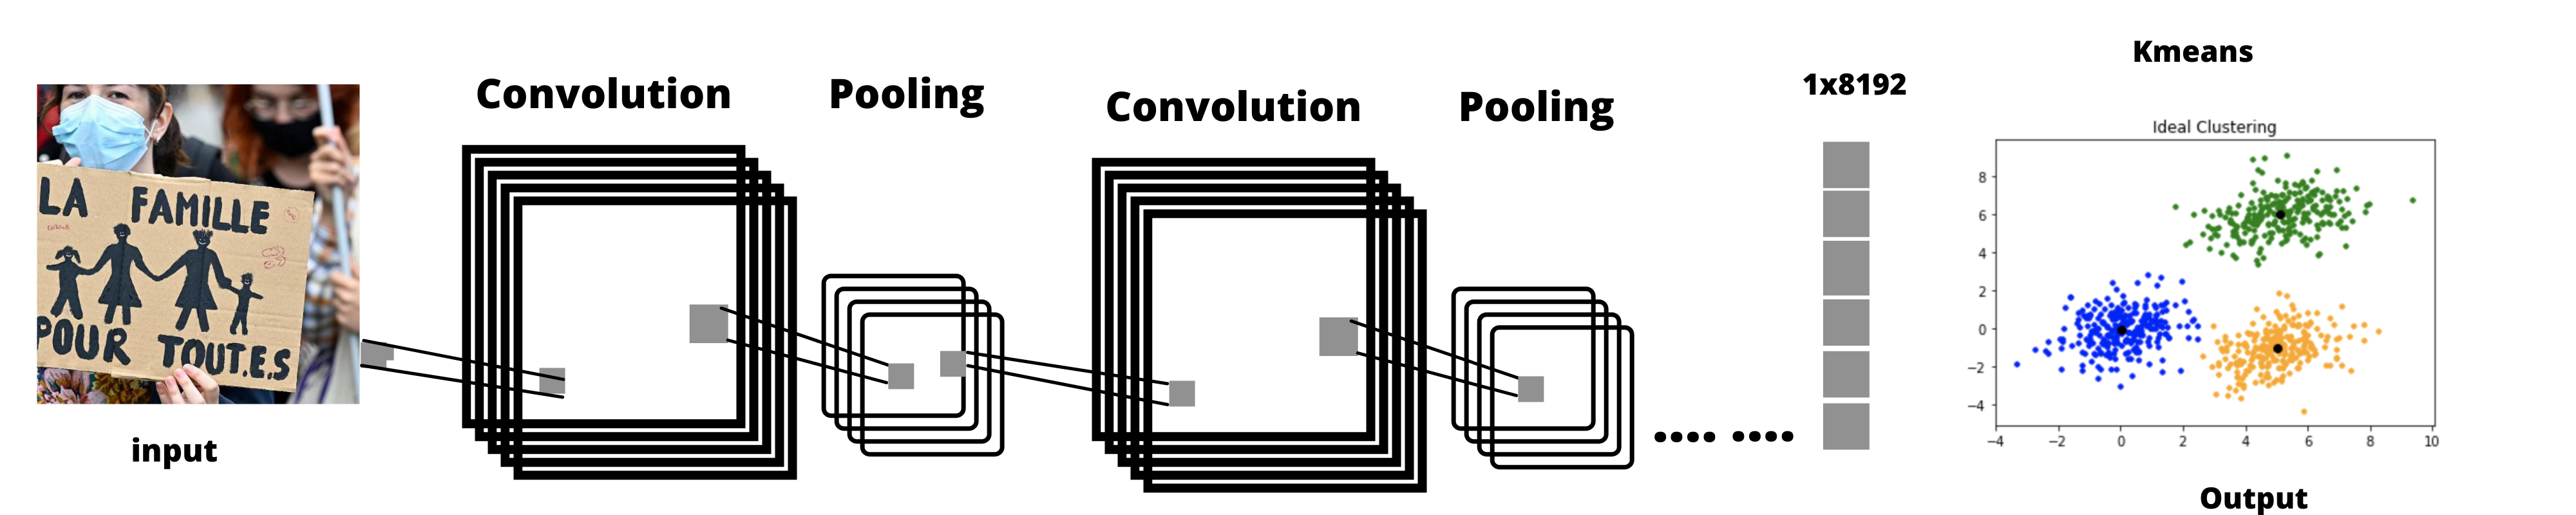

Le réseau de neurones convolutifs (CNN) est l'unes
des architectures de réseaux de neurones artificiels feed-forward
fréquemment utilisé dans les problèmes de vision par ordinateur tels que l'image
classification. La différence entre CNN et multicouche
réseau perceptron (MLP) est son utilisation de la convolution
couches, regroupement et non-linéarités telles que tanh, sigmoïde,
et ReLU

On va récupérer notre jeux de données de kaggle (le jeux de données contient des photos issues de twitter )

Nous l'avons upload sur Kaggle pour faciliter son chargement 

In [1]:
 !pip install -q kaggle

In [ ]:
!pip install requests

In [2]:
!pip install -q tfds-nightly

     |████████████████████████████████| 4.2 MB 23.9 MB/s 
     |████████████████████████████████| 76 kB 4.7 MB/s 


In [3]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amassinnacerddine","key":"a46d7e975a447b86bae3fcf578a13f13"}'}

In [4]:
 ! mkdir ~/.kaggle 
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download  'amassinnacerddine/projetnedra-mt-an'

 98% 520M/528M [00:11<00:00, 78.8MB/s]
100% 528M/528M [00:12<00:00, 45.9MB/s]


In [6]:
! unzip projetnedra-mt-an.zip

Archive:  projetnedra-mt-an.zip
  inflating: 1/00008871284d1fa8b6d188d7cffe4714c9b8bcab.jpg  
  inflating: 1/000225fc2f069e3ae8bba33e7d05d3edcd8b0883.jpg  
  inflating: 1/0008255f72057dbf97e229199e6595e2deebecfd.jpg  
  inflating: 1/00082a4dc6f04d975a0e759fffd2b994ccdb5bb9.jpg  
  inflating: 1/000ae4b433acb21229b17679d28f9a148fad3429.jpg  
  inflating: 1/000c5cbd1bcb09e74453293c5b31fdb31516cc66.jpg  
  inflating: 1/000ce5a59c7f8c78748817b81b69ae81a8c38f16.jpg  
  inflating: 1/000d9a5b6bf9e14b291fe5b645d5396347246cc3.jpg  
  inflating: 1/000fc54396a16e374c2ff4a579de19568b138921.jpg  
  inflating: 1/0015a3e8e701b9ce5ffa63cd92ce3f830d95f847.jpg  
  inflating: 1/001dee6bb8c2280e1182e11d5fb87f5a5272753b.jpg  
  inflating: 1/001e6f0d1c16116a81391fc902417a7d61147985.jpg  
  inflating: 1/001fdacde880e12e4e8101f1f24a6b223f3f843a.jpg  
  inflating: 1/0020edd9b3fe34194baf4fe922373d1844478cf6.jpg  
  inflating: 1/00231d3e55b16b13eaf374ac4eea8bcb0466f3e5.jpg  
  inflating: 1/0023593bc7d99ef1dded8b2

In [40]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import random
from tensorflow.keras import layers
import shutil
from tensorflow import keras
from keras import backend
import cv2
import sys
import requests
from tensorflow.keras.applications import ResNet101V2
from matplotlib import pyplot

In [9]:
import pathlib


data_dir = pathlib.Path('/content/1/')

In [10]:
data_dir

PosixPath('/content/1')

In [ ]:
!rm -rf /content/dataset/

In [11]:

image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)


3498


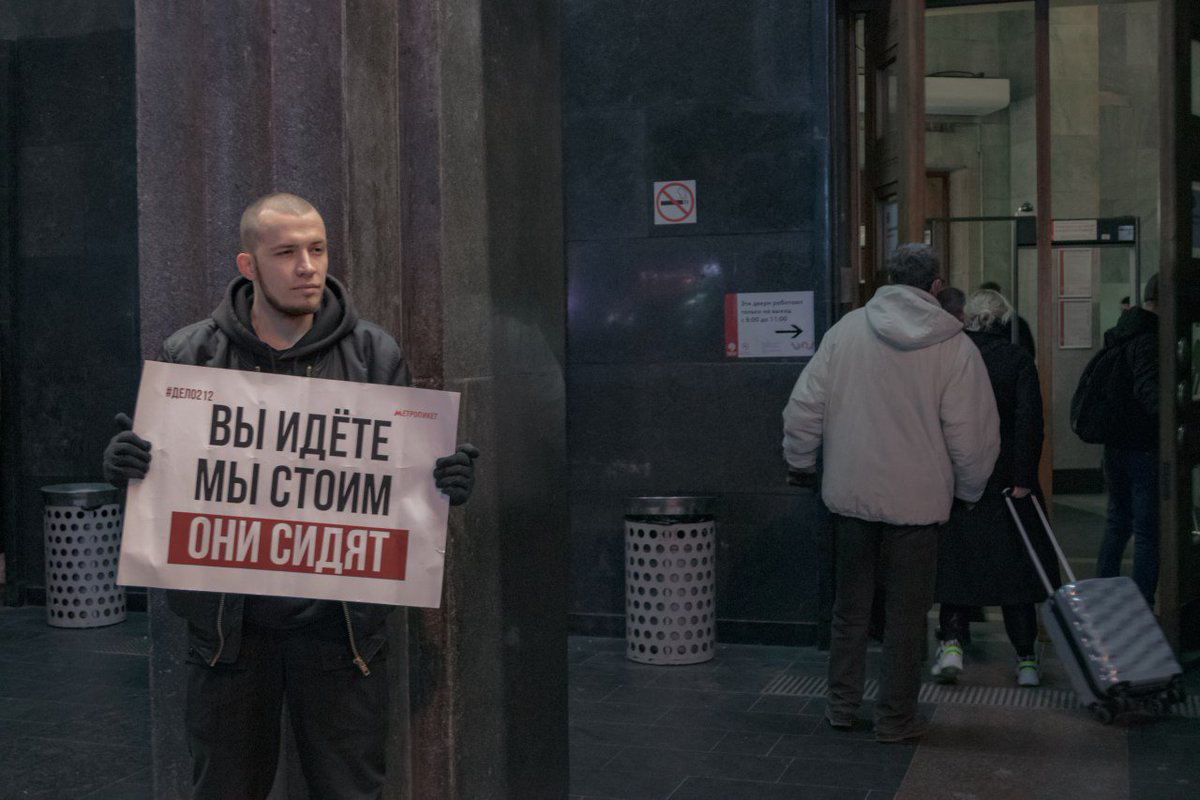

In [12]:
img = list(data_dir.glob('*.jpg'))
PIL.Image.open(str(img[random.randint(0, len(img)-1)]))




In [ ]:
import os
os.path.join(data_dir,'images')

'/content/1/images'

In [13]:
 !mkdir /content/dataset

##Split directory into train test and validation 60% 20% 20%

In [14]:
train_dir = os.path.join('/content/dataset', 'training')
test_dir = os.path.join('/content/dataset', 'test')
validation_dir = os.path.join('/content/dataset', 'validation')
if not os.path.exists(train_dir) or not os.path.exists(test_dir) or not  os.path.exists(test_dir) :
  os.mkdir(train_dir)
  os.mkdir(test_dir)
  os.mkdir(validation_dir)

img = list(data_dir.glob('*.jpg'))
print(len(img))
for i in range(0,int(len(img)*0.6)):
   f_base = os.path.basename(img[i])
   shutil.move(img[i], os.path.join(train_dir, f_base))

img = list(data_dir.glob('*.jpg'))   
print(len(img))
for i in range(0,int(len(img)*0.2)):
   f_base = os.path.basename(img[i])
   shutil.move(img[i], os.path.join(test_dir, f_base))

img = list(data_dir.glob('*.jpg'))
print(len(img))
for i in range(0,int(len(img)*0.2)):
   f_base = os.path.basename(img[i])
   shutil.move(img[i], os.path.join(validation_dir, f_base))


3498
1400
1120


In [15]:
conv_base = ResNet101V2(include_top=False,input_shape=(64,64,3))

171327488/171317808 [==============================] - 4s 0us/step


In [16]:
model=tf.keras.models.Sequential([
                                  conv_base,tf.keras.layers.Flatten()

])

In [17]:
model.compile()

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 2, 2, 2048)        42626560  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
Total params: 42,626,560
Trainable params: 42,528,896
Non-trainable params: 97,664
_________________________________________________________________


In [19]:
batch_size = 32
img_height = 64
img_width = 64

print(data_dir)

train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/dataset/training',
  labels=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/dataset/test',
  labels=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


validation_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/dataset/validation',
  labels=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



/content/1
Found 2098 files belonging to 1 classes.
Found 280 files belonging to 1 classes.
Found 224 files belonging to 1 classes.


In [24]:
result_cnn=model.predict(validation_ds)

In [28]:

len(result_cnn[0])

8192

In [42]:
import numpy as np
import tensorflow as tf



def input_fn():
  return tf.compat.v1.train.limit_epochs(
      tf.convert_to_tensor(result_cnn, dtype=tf.float32), num_epochs=1)

num_clusters = 5
kmeans = tf.compat.v1.estimator.experimental.KMeans(
    num_clusters=num_clusters, use_mini_batch=False)

# train
num_iterations = 100
previous_centers = None
for x in range(num_iterations):
  kmeans.train(input_fn)
  cluster_centers = kmeans.cluster_centers()
  if previous_centers is not None:
    print ('delta:', cluster_centers - previous_centers)
  previous_centers = cluster_centers
  print ('score:', kmeans.score(input_fn))
print ('cluster centers:', cluster_centers)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpzrwi5qax', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:ten

In [45]:
# map the input points to their clusters
cluster_indices = list(kmeans.predict_cluster_index(input_fn))
for i, point in enumerate(points):
  cluster_index = cluster_indices[i]
  center = cluster_centers[cluster_index]
  print ('image:', point, 'is in cluster', cluster_index, 'centered at', center)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpzrwi5qax/model.ckpt-199
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
image: [706.74800119 563.21652408] is in cluster 3 centered at [0. 0. 0. ... 0. 0. 0.]
image: [564.13298854 646.52256126] is in cluster 0 centered at [0. 0. 0. ... 0. 0. 0.]
image: [916.59442216 898.93223756] is in cluster 1 centered at [0. 0. 0. ... 0. 0. 0.]
image: [889.1434932  946.81629824] is in cluster 0 centered at [0. 0. 0. ... 0. 0. 0.]
image: [713.27576948 674.2832183 ] is in cluster 4 centered at [0. 0. 0. ... 0. 0. 0.]
image: [574.79914992   0.67516157] is in cluster 4 centered at [0. 0. 0. ... 0. 0. 0.]
image: [992.61068942 773.28368643] is in cluster 0 centered at [0. 0. 0. ... 0. 0. 0.]
image: [809.23298419 863.26375831] is in cluster 3 centered at [0. 0. 0. ... 0. 0. 0.]
image: [390.02940969  54.85063412] is

In [44]:
x_c1,y_c1=[],[]
x_c2,y_c2=[],[]
x_c3,y_c3=[],[]
x_c4,y_c4=[],[]
x_c4,y_c4=[],[]
x_c5,y_c5=[],[]
for i, point in enumerate(points):
  cluster_index = cluster_indices[i]
  center = cluster_centers[cluster_index]
  
  if cluster_index==0:
    x_c1.append(point[0])
    y_c1.append(point[1])

  else:
      if   cluster_index==1:
        x_c2.append(point[0])
        y_c2.append(point[1])
      else:
        if cluster_index==2:
            x_c3.append(point[0])
            y_c3.append(point[1])  
        else:
          if cluster_index==3:
            x_c4.append(point[0])
            y_c4.append(point[1])
          else: 
            x_c5.append(point[0])
            y_c5.append(point[1])     

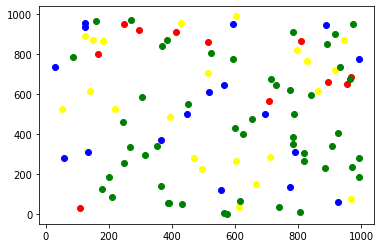

In [41]:
pyplot.scatter(x_c1, y_c1, c = 'red')
pyplot.scatter(x_c2, y_c2, c = 'yellow')
pyplot.scatter(x_c3, y_c3, c = 'blue')
pyplot.scatter(x_c4, y_c4, c = 'green')
pyplot.scatter(x_c5, y_c5, c = 'green')